## Simulations for Regression Problem

I use galaxies from the RedMaGiC catalog to obtain some realistic properties of the deflector galaxy, but I simulate its light profile. The fits file include the image of the complete simulation, and the data with Y6 table columns and the true modeling labels.

In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('dark_background')
import random
from scipy.stats import skewnorm
import copy

if(script): 
    from tqdm import tqdm
else:
    from tqdm.notebook import tqdm

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [3]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.#6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 10.,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 10.,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 10.,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 45 # 45

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [4]:
#Make another function to plot the real deflector vs the simulated deflector

#Makes 3 plots per image: source simulation, lens cutout, complete simulation
def make_graphs(name, source, lens_img):
    source_g, source_r, source_i = source[0], source[1], source[1]
    lens_g, lens_r, lens_i = lens_img[0], lens_img[1], lens_img[2]
    
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(source_g, source_r, source_i, Q=11., stretch=40.)
    ax1.set_title('Source(s)')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')

    rgb = make_lupton_rgb(lens_g, lens_r, lens_i, Q=11., stretch=40.)
    ax2.set_title('Lens')
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    cutout = ax2.imshow(rgb, aspect='equal')
            
    rgb = make_lupton_rgb(source_g+lens_g, source_r+lens_r, source_i+lens_i, Q=11., stretch=40.)
    ax3.set_title('Complete Simulation')
    ax3.xaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])
    projection = ax3.imshow(rgb, aspect='equal')
   
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [5]:
# Writes fit file
def write_fit_file(name, x, data):
    my_types = {'Y6_COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'Y3_COADD_OBJECT_ID': int, 'REFMAG': float, 'REFMAG_ERR': float, 'LUM': float, 'ZREDMAGIC': float,
       'ZREDMAGIC_E': float, 'CHISQ': float, 'Z_LENS': float, 'MAG_G': float, 'MAG_R': float, 'MAG_I': float, 
        'MAG_Z': float, 'MAG_ERR_G': float, 'MAG_ERR_R': float, 'MAG_ERR_I': float, 'MAG_ERR_Z': float, 
        'ZG': float, 'ZR': float, 'ZI': float, 'ZZ': float, 'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 
        'IMAFLAGS_ISO_R': int, 'IMAFLAGS_ISO_I': int, 'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int, 'FWHM_WMEAN_G': float,
       'FWHM_WMEAN_R': float, 'FWHM_WMEAN_I': float, 'FWHM_WMEAN_Z': float, 'SKYBRITE_WMEAN_G': float,
       'SKYBRITE_WMEAN_R': float, 'SKYBRITE_WMEAN_I': float, 'SKYBRITE_WMEAN_Z': float, 'Z1': float, 'LENSED_MAG': float,     
       'mag_1': float, 'ISOLATION': float, 'EINSTEIN_RADIUS': float, 'MAGNIFICATION': float, 'POSITION1': float,
        'e1_lens': float, 'e2_lens': float, 'center_x_lens': float, 'center_y_lens': float, 
        'R_sersic_source_light': float, 'n_sersic_source_light': float, 'e1_source_light': float,
       'e2_source_light': float, 'center_x_source': float, 'center_y_source': float,
       'R_sersic_lens_light': float, 'n_sersic_lens_light': float, 'e1_lens_light': float, 'e2_lens_light': float}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(file_path + name + '.fits', overwrite=True)   
    hdu_list.close()

In [6]:
# To choose a source position close to the caustics
def pick_center(ra_caustic_list, dec_caustic_list):
    l = random.randint(0, len(ra_caustic_list)-1)
    t = skewnorm.rvs(a=-5, size=10000, loc=0.8, scale=0.435) #a: skew, loc: center, scale:sigma
    noise_ra, noise_dec = t[np.random.randint(0,10000)], t[np.random.randint(0,10000)]
    s_ra = 1 if random.randint(0, 1) else -1
    s_dec = 1 if random.randint(0, 1) else -1
    noise_ra, noise_dec = s_ra*noise_ra, s_dec*noise_dec
    return(ra_caustic_list[l] + noise_ra, dec_caustic_list[l] + noise_dec)

#Calculating distance of the furtherst lensed source image to the deflector
def furtherst_distance(theta_ra, theta_dec):
    distances_list = []
    for i in range(len(theta_ra)):
        distances_list.append(np.sqrt(theta_ra[i]**2 + theta_dec[i]**2))
    return(max(distances_list))

#Calculating ~total flux
def calculate_flux(object, band):
    flux = np.sum(object[band])
    return(flux)

#Calculating AB magnitude
def calculate_magnitude(object, band):
    f = calculate_flux(object, band)
    m = -2.5*np.log10(f*10**(-12))
    return(m)

#Calculating magnification of the source
def calculate_magnification(delta_m):
    M = 100**(delta_m/5)
    return(M)

#Estimating how bright the source is in comparison to the deflector (in the relevant pixels)
def isolation(image_source, image_lens, cumulative=0.9):
    """Compute a statistic to measure degree of source image isolation.
   
    Use the simulated image of the lensed source to define an effective weight
    map. Use the weight map to compute the weighted average flux within pixels 
    from the lensed source images and from the foreground lens. Return the 
    effective fraction of the total flux within this weighted aperture that is
    attributed to the source.

    isolation = <source_flux> / (<source_flux> + <lens_flux>)
 
    A weighted aperture is obtained by converting the simulated source image 
    into a PDF, removing the set of faint pixels that contain (1 - cumulative)
    of the total flux, and normalizing the weighted aperture such that integral 
    over all pixels in equal to one.

    Parameters
    ----------
    image_source : `numpy.ndarray` [`float`]
        Image of simulated lensed source; shape (n, n)
    image_lens : `np.ndarray` [`float`]
        Image of lens and other foreground objects; shape (n, n)
    cumulative : `float`
        Fraction of lens total flux to use when defining an aperture. 
        Default = 0.9.
    
    Returns
    -------
    isolation : `float`
        Mean flux fraction attributed to the source images within the weighted
        apertue.
    """
    weight = image_source  / np.sum(image_source)
    weight_sorted = np.sort(weight.flatten())
    threshold = weight_sorted[np.cumsum(weight_sorted) > (1. - cumulative)][0]
    aperture = weight > threshold

    weight_aperture = weight * aperture / np.sum(weight * aperture)

    mean_lens = np.sum(weight_aperture * image_lens) 
    mean_sources = np.sum(weight_aperture * image_source)
    isolation = mean_sources / (mean_sources + mean_lens)
    return isolation

# From redshift get magnitude, sersic radius & ellipticity
def distribution(z, data):
    dz = 0.1 # Range of redshift for filtering
    new_data = data[data['DNF_ZMEAN_SOF'] > z - dz] [data['DNF_ZMEAN_SOF'] < z + dz] 
    new_data = new_data[new_data['MAG_PSF_G'] < MMAX]
    random_object = new_data.sample()
    mg, mr, mi = random_object['MAG_PSF_G'].values[0], random_object['MAG_PSF_R'].values[0], random_object['MAG_PSF_I'].values[0]
    rg, rr, ri = random_object['FLUX_RADIUS_G'].values[0], random_object['FLUX_RADIUS_R'].values[0], random_object['FLUX_RADIUS_I'].values[0]
    e1, e2 = random_object['SOF_CM_G_1'].values[0], random_object['SOF_CM_G_2'].values[0]
    magnitude = {'mg': mg-1, 'mr': mr-1, 'mi': mi-1}
    radius = {'rg': rg*DES_camera['pixel_scale'], 'rr': rr*DES_camera['pixel_scale'], 'ri': ri*DES_camera['pixel_scale']}
    ellipticity = {'e1': e1, 'e2': e2}
    return(magnitude, radius, ellipticity)
    #z = 1.7 Max

# Cleaning data to choose realistic light profiles for the source galaxy
def distribution_data(path):
    data_dist = pd.read_csv(path)
    data_dist = data_dist[data_dist['MAG_PSF_G'] < 30.] [data_dist['MAG_PSF_R'] < 30.] [data_dist['MAG_PSF_I'] < 30.]
    data_dist = data_dist[data_dist['SOF_CM_G_1'] > -100.][data_dist['SOF_CM_G_2'] > -100.]
    data_dist = data_dist[data_dist['DNF_ZMEAN_SOF'] > 0.01][data_dist['DNF_ZMEAN_SOF'] < 2.9]
    data_dist = data_dist.sort_values('DNF_ZMEAN_SOF').reset_index()
    return(data_dist)


In [7]:
def image_source_lens(redshifts, kwargs_bands, kwargs_lens, kwargs_lens_light_mag, kwargs_source_mag):
    kwargs_g_band, kwargs_r_band, kwargs_i_band = kwargs_bands[0], kwargs_bands[1], kwargs_bands[2]
    kwargs_lens_light_mag_g, kwargs_lens_light_mag_r, kwargs_lens_light_mag_i = kwargs_lens_light_mag[0], kwargs_lens_light_mag[1], kwargs_lens_light_mag[2]
    kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i = kwargs_source_mag[0], kwargs_source_mag[1], kwargs_source_mag[2]
    
    #Image of the lensed source (without noise)
    kwargs_model_physical = {'lens_model_list': ['SIE'], 
                'lens_redshift_list': [redshifts['lens']], 'source_light_model_list': ['SERSIC_ELLIPSE'], 
                'source_redshift_list': [redshifts['source1']], 'cosmo': cosmo, 'z_source': redshifts['source1']}
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    source_g = imSim_g.image(kwargs_lens, kwargs_source_g)
    source_r = imSim_r.image(kwargs_lens, kwargs_source_r)
    source_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
    #Image of the deflector galaxy, includes the noise
    kwargs_source_mag_g[0]['magnitude'] = 40 #Makes an 'invisible' lensed source
    kwargs_source_mag_r[0]['magnitude'] = 40
    kwargs_source_mag_i[0]['magnitude'] = 40
    kwargs_model_physical = {'lens_model_list': ['SIE'], 'lens_light_model_list': ['SERSIC_ELLIPSE'], 
                'lens_redshift_list': [redshifts['lens']], 'source_light_model_list': ['SERSIC_ELLIPSE'], 
                'source_redshift_list': [redshifts['source1']], 'cosmo': cosmo, 'z_source': redshifts['source1']}
    
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_g, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_r, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_i, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    lens_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    lens_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r)
    lens_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i)
    lens_g += sim_g.noise_for_model(model=lens_g)
    lens_r += sim_r.noise_for_model(model=lens_r)
    lens_i += sim_i.noise_for_model(model=lens_i)
    return([source_g, source_r, source_i], [lens_g, lens_r, lens_i])

In [8]:
def simulation(model, redshifts, lens_image, lens, cuts, additional_info, kwargs_bands):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'], 'lens_redshift_list': [redshifts['lens']],  
        'lens_light_model_list': ['SERSIC_ELLIPSE'], 'source_light_model_list': ['SERSIC_ELLIPSE'],  
         'source_redshift_list': [redshifts['source1']], 'cosmo': cosmo, 'z_source': redshifts['source1']} 
                          
    kwargs_g_band, kwargs_r_band, kwargs_i_band = kwargs_bands[0], kwargs_bands[1], kwargs_bands[2]
    
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': lens['sigma'], 'center_x': 0, 'center_y': 0, 'e1': lens['e1'], 'e2': lens['e2']}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    
    #caustics and critical curves
    ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = model['model_ext'].critical_curve_caustics(kwargs_lens, 
                                                                compute_window=15, grid_scale=0.01, center_x=0, center_y=0)
    if(len(ra_caustic_list)==0): return('No caustics')
    ra_caustic_list, dec_caustic_list = ra_caustic_list[0], dec_caustic_list[0]
    
    #cut on the Einstein radius
    if(kwargs_lens[0]['theta_E'] < cuts['E_min'] or kwargs_lens[0]['theta_E'] > cuts['E_max']):
        return ('No cut E: {:.3f}'.format(kwargs_lens[0]['theta_E']))
    
    #cut comparing Einstein radius and size of the lens
    E_rflux = kwargs_lens[0]['theta_E']/additional_info['FLUX_RADIUS_G']
    if(E_rflux < cuts['theta_E_r_f_min'] or E_rflux > cuts['theta_E_r_f_max']):
        return ('No cut E_r: {:.3f}'.format(E_rflux))
    
    #lens light
    kwargs_lens_light_mag_g = [{'magnitude': lens['mag_g'], 'R_sersic': lens['R_sersic'], 'n_sersic': lens['n_sersic'], 
                                'e1': lens['e1_light'], 'e2': lens['e2_light'], 'center_x': 0, 'center_y': 0}]
    kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_r[0]['magnitude'], kwargs_lens_light_mag_r[0]['R_sersic'] = lens['mag_r'], lens['R_sersic']
    kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_i[0]['magnitude'], kwargs_lens_light_mag_i[0]['R_sersic'] = lens['mag_i'], lens['R_sersic']
    
    #Source
    mag1, rad1, ellip1 = distribution(redshifts['source1'], data = data_dist)
    n1 = random.uniform(0.5, 6.)
    #Pick source position
    c1x, c1y = pick_center(ra_caustic_list, dec_caustic_list)
    
    theta_ra1, theta_dec1 = model['solver'].image_position_from_source(c1x, c1y, kwargs_lens)
    if(len(theta_ra1)==0): return('No image positions')
    #magni1 = model['lensModel'].magnification(theta_ra1, theta_dec1, kwargs_lens)
    distance1 = furtherst_distance(theta_ra1, theta_dec1)
    #Cut on image separation
    if(distance1 < cuts['min_image'] or distance1 > cuts['max_image']):
        return('No cut image: {:.3f}'.format(distance1))
    #Source light - other parameters:
    kwargs_source_mag_g = [{'magnitude': mag1['mg'], 'R_sersic': rad1['rg'], 'n_sersic': n1,
                              'e1': ellip1['e1'], 'e2': ellip1['e2'], 'center_x': c1x, 'center_y': c1y}]
    kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_r[0]['magnitude'], kwargs_source_mag_r[0]['R_sersic'] = mag1['mr'], rad1['rr']
    kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_i[0]['magnitude'], kwargs_source_mag_i[0]['R_sersic'] = mag1['mi'], rad1['ri']
    
    #Getting each image (lens, source) separated:
    kwargs_lens_light_mag = [kwargs_lens_light_mag_g, kwargs_lens_light_mag_r, kwargs_lens_light_mag_i]
    kwargs_source_mag = [kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i]
    
    source, lens_img = image_source_lens(redshifts, kwargs_bands, kwargs_lens, kwargs_lens_light_mag, kwargs_source_mag)
    source_g, source_r, source_i = source[0], source[1], source[1]
    lens_g, lens_r, lens_i = lens_img[0], lens_img[1], lens_img[2]
    
    if(np.isnan(np.sum(source_g)) or np.isnan(np.sum(lens_g))): #Cut if image is not valid
        return('IS NAN!!!!!')
    
    object_sim = np.array([source_g, source_r, source_i])
    m = calculate_magnitude(object_sim, 0) #band 0 = g band
    if(m > cuts['mmax'] or m < cuts['mmin']): #Cut on the magnitude of the lensed source image
        return ('No cut mag: {:.3f}'.format(m))
    
    #lens_g, lens_r, lens_i = lens_image[0], lens_image[1], lens_image[2]          Previous code
    iso_g, iso_i, iso_r = isolation(source_g, lens_g), isolation(source_i, lens_i), isolation(source, lens_r)
    iso_ave = np.mean([iso_g, iso_i, iso_r])
    Mag = calculate_magnification(mag1['mg'] - m)
    
    if(iso_ave < cuts['iso_min'] or iso_ave > cuts['iso_max'] or np.isnan(iso_ave)): #Cut isolation
        return('No cut isolation: {:.3f}'.format(iso_ave))
    
    if(Mag < cuts['magni_min'] or Mag > cuts['magni_max'] or np.isnan(Mag)): #Cut magnification
        return('No cut magnification: {:.3f}'.format(Mag))
    
    parameters = {'Z1': redshifts['source1'], 'LENSED_MAG': m, 'mag_1': mag1['mg'], 'ISOLATION': iso_ave, 
                  'EINSTEIN_RADIUS': kwargs_lens[0]['theta_E'], 'MAGNIFICATION': Mag, 'POSITION1': distance1,
                 'e1_lens': lens['e1'], 'e2_lens': lens['e1'], 'center_x_lens': 0, 'center_y_lens': 0, 
                  'R_sersic_source_light': kwargs_source_mag_g[0]['R_sersic'], 
                  'n_sersic_source_light': kwargs_source_mag_g[0]['n_sersic'], 'e1_source_light': ellip1['e1'], 
                  'e2_source_light': ellip1['e2'], 'center_x_source': c1x, 'center_y_source': c1y, 
                  'R_sersic_lens_light': kwargs_lens_light_mag_g[0]['R_sersic'], 
                  'n_sersic_lens_light': kwargs_lens_light_mag_g[0]['n_sersic'], 'e1_lens_light': lens['e1_light'], 
                  'e2_lens_light': lens['e2_light']}    
    
    tmp_series = pd.Series(parameters)
    additional_info = pd.concat([additional_info, tmp_series])
    df_test = pd.DataFrame(additional_info).transpose()
    parameters = df_test
    
    #No data augmentation (rotations, or reflections) because the true labels would change: source position complicated
    ele_sim = np.array([source_g + lens_g, source_r + lens_r, source_i + lens_i]) 
    
    if(not script):
        #print(mag1['mg']-mag1['mr'], mag1['mg']-mag1['mi'])
        #print(lens['n_sersic'], lens['R_sersic'])
        #print(kwargs_g_band['seeing'], kwargs_r_band['seeing'], kwargs_i_band['seeing'])
        #print(kwargs_g_band['sky_brightness'], kwargs_r_band['sky_brightness'], kwargs_i_band['sky_brightness'])
        make_graphs('example_simulations', source, lens_img)
        #make_graphs('example_simulations', image_g, image_r, image_i, lens_image[0], lens_image[1], lens_image[2])
        
    return ('ok', ele_sim, parameters)

In [9]:
def simulations_from_data(lenses, complete_data, num):
    num_sim = 0
    images_sim = np.zeros((1,3,numpix,numpix))
    data_sim = pd.DataFrame()

    lens_model_list = ['SIE']
    lensModel = LensModel(lens_model_list=lens_model_list)
    lensModelExt = LensModelExtensions(lensModel)
    solver = LensEquationSolver(lensModel)
    
    model = {'lensModel': lensModel, 'model_ext': lensModelExt, 'solver': solver}
    
    with tqdm(total=num) as pbar:
        while (num_sim < num):
            l = random.randint(0, len(complete_data)-1)
            data_point = complete_data.iloc[l]
            lens_image = lenses[l]
            
            DES_g_band_obs['seeing'] = data_point['FWHM_WMEAN_G'] 
            DES_r_band_obs['seeing'] = data_point['FWHM_WMEAN_R']
            DES_i_band_obs['seeing'] = data_point['FWHM_WMEAN_I']
            
            DES_g_band_obs['sky_brightness'] = data_point['SKYBRITE_WMEAN_G']/26 #np.random.normal(loc=20., scale=0.6) #data_point['SKYBRITE_WMEAN_G']/26
            DES_r_band_obs['sky_brightness'] = data_point['SKYBRITE_WMEAN_R']/64 #np.random.normal(loc=19., scale=0.8) #data_point['SKYBRITE_WMEAN_R']/64
            DES_i_band_obs['sky_brightness'] = data_point['SKYBRITE_WMEAN_I']/84 #np.random.normal(loc=18., scale=0.8) #data_point['SKYBRITE_WMEAN_I']/84
            
            kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
            kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
            kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)
            
            kwargs_bands = [kwargs_g_band, kwargs_r_band, kwargs_i_band]

            z_lens = data_point['Z_LENS']
            z1_max = skewnorm.rvs(a=-5, size=10000, loc=1.1, scale=0.4)  #0.2, 1.2   0.8 for DSPL
            z1_max = z1_max[np.random.randint(0,1000)]
            z_source1 = z_lens + z1_max # 1.2
            if(z_lens < 0.15): continue
            if(z1_max < 0.1 or z_source1 > 2.): continue
            
            redshifts = {'lens': z_lens, 'source1': z_source1}
            angle, ratio = param.ellipticity2phi_q(data_point['SOF_BDF_G_1'], data_point['SOF_BDF_G_2'])
            angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
            ratio = random.uniform(0.001, 1) #distribution for the axis ratio
            e1, e2 = param.phi_q2_ellipticity(angle, ratio)
            #light distribution for lens
            mag = {'mg': data_point['MAG_I'], 'mr': data_point['MAG_R'], 'mi': data_point['MAG_G']}
            n = random.uniform(0.5, 3.5)
            rad = {'rg': data_point['FLUX_RADIUS_G']*0.2637}
            
            lens = {'sigma': random.uniform(300, 650), 'e1': e1, 'e2': e2, 'mag_g': mag['mg'], 'mag_r': mag['mr'],
                    'mag_i': mag['mi'], 'R_sersic': rad['rg'], 'n_sersic': n, 'e1_light': data_point['SOF_BDF_G_1'], 
                    'e2_light': data_point['SOF_BDF_G_2']} #single: 300-650
            status = simulation(model, redshifts, lens_image, lens, cuts, data_point, kwargs_bands)
            
            if(status[0] == 'ok'):
                ele_sim, parameters = status[1], status[2]
                images_sim = np.append(images_sim, [ele_sim], axis = 0)
                data_sim = data_sim.append(parameters, ignore_index=True)
                num_sim += 1
                pbar.update(1)
                
    images_sim = np.delete(images_sim, 0, axis = 0)
    return(images_sim, data_sim)

In [10]:
def run_everything(seed, num_sim, name_file):
    seed_everything(seed)

    hdu_list = fits.open(lenses_path)
    lenses = hdu_list[1].data 
    complete_data = hdu_list[2].data[:]
    complete_data = Table(complete_data)
    complete_data = complete_data.to_pandas()
    complete_data = complete_data.rename({'ZSPEC': 'Z_LENS'}, axis=1)
    print(len(complete_data))
    hdu_list.close()

    images_sim, data_sim = simulations_from_data(lenses, complete_data, num = num_sim)
    write_fit_file(name_file, images_sim, data_sim)

In [11]:
inipath = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
path_dist = inipath + 'Data/source_distributions.csv'
lenses_path = inipath + 'Data/Sim_complete/new_all_redmagic/' + 'all_redmagic_final.fits'
file_path = 'Data/fit_files/'

if(cluster):
    path_dist = 'source_distributions.csv'
    lenses_path = 'all_redmagic_final.fits'
    file_path = ''

data_dist = distribution_data(path_dist)
data_dist = data_dist[data_dist['MAG_PSF_G'] - data_dist['MAG_PSF_R'] > -2.2]
data_dist = data_dist[data_dist['MAG_PSF_R'] - data_dist['MAG_PSF_I'] > -2.2] #Typical colors of lensed sources

MMAX = 24.7 #For source light distribution
mmin, mmax, E_min, E_max, iso_min, iso_max, magni_min, magni_max = 18., 23.5, 0.2, 6.6, 0.3, 1000, 3.2, 1000
theta_E_r_f_min, theta_E_r_f_max, min_image, max_image = 0.1, 1000., 1.1, 5.5
min_col = 0.3
cuts = {'E_max': E_max, 'E_min': E_min, 'mmax': mmax, 'mmin': mmin, 'iso_min': iso_min, 'iso_max': iso_max,
        'magni_min': magni_min, 'magni_max': magni_max, 'theta_E_r_f_min': theta_E_r_f_min, 
        'theta_E_r_f_max': theta_E_r_f_max, 'min_image': min_image, 'max_image': max_image, 'min_col': 0.3}

50380


  0%|          | 0/10 [00:00<?, ?it/s]

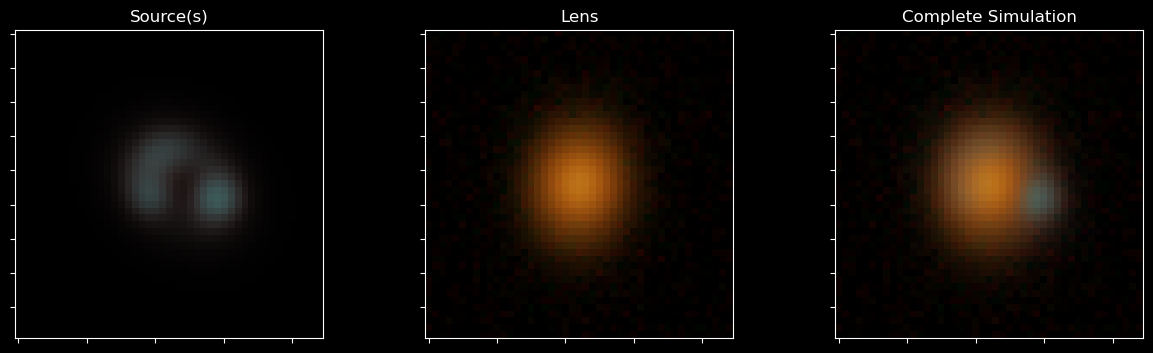

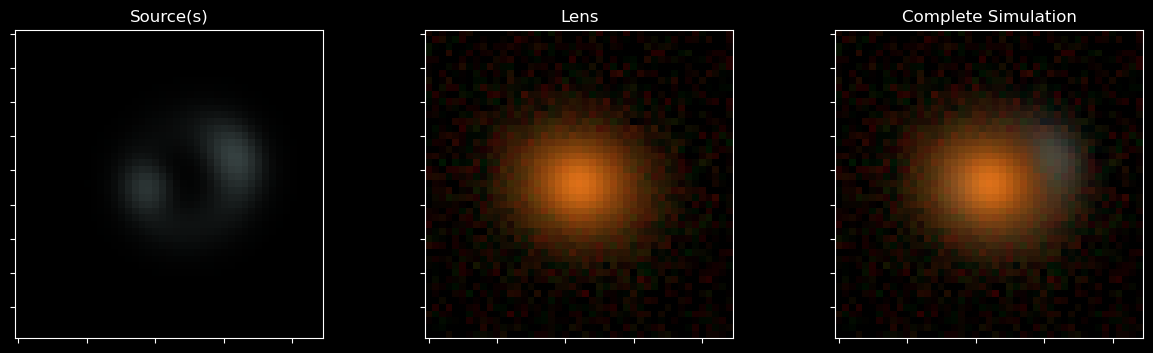

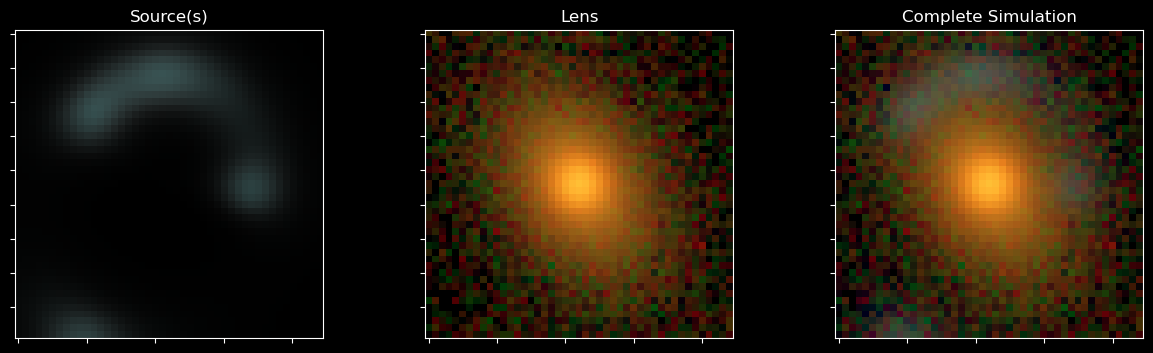

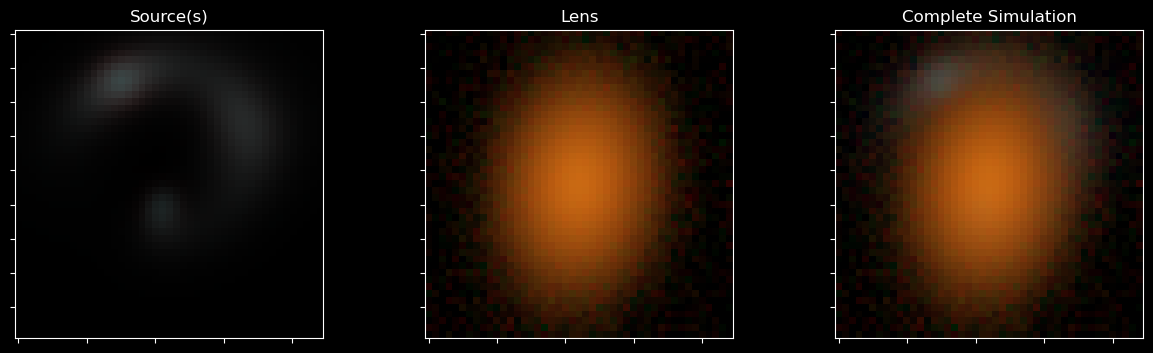

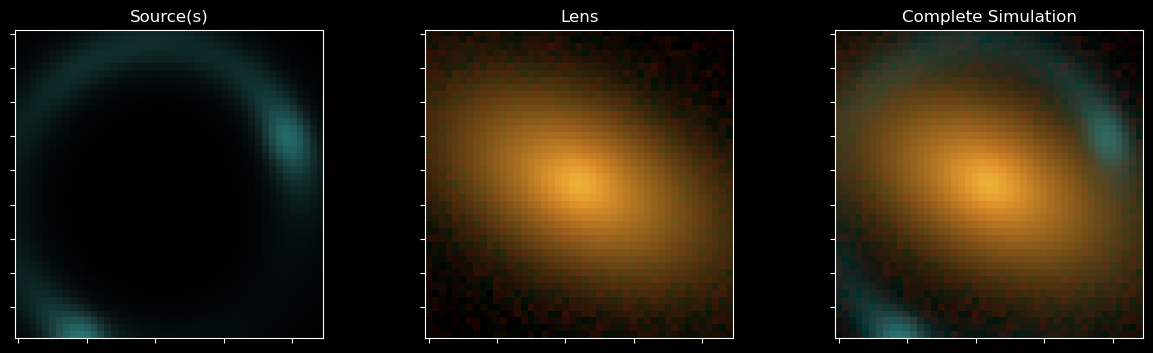

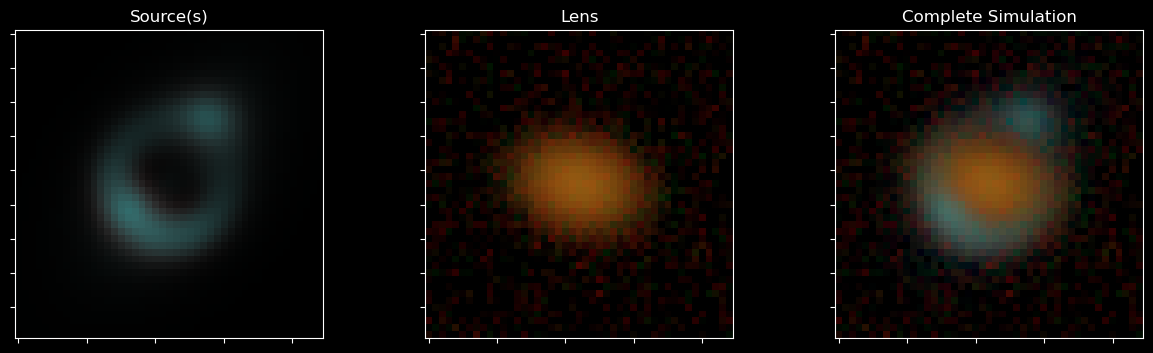

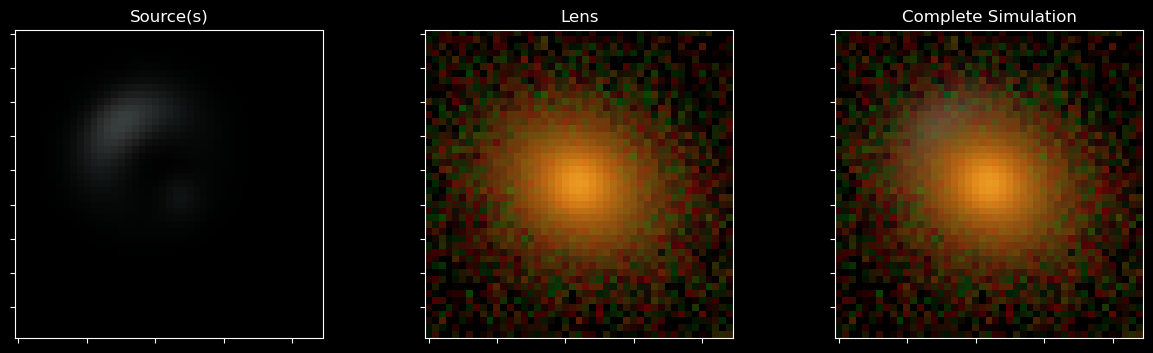

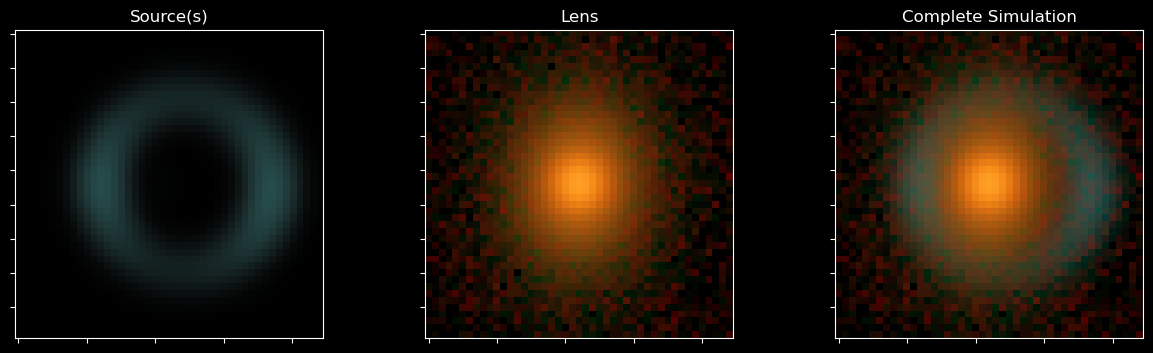

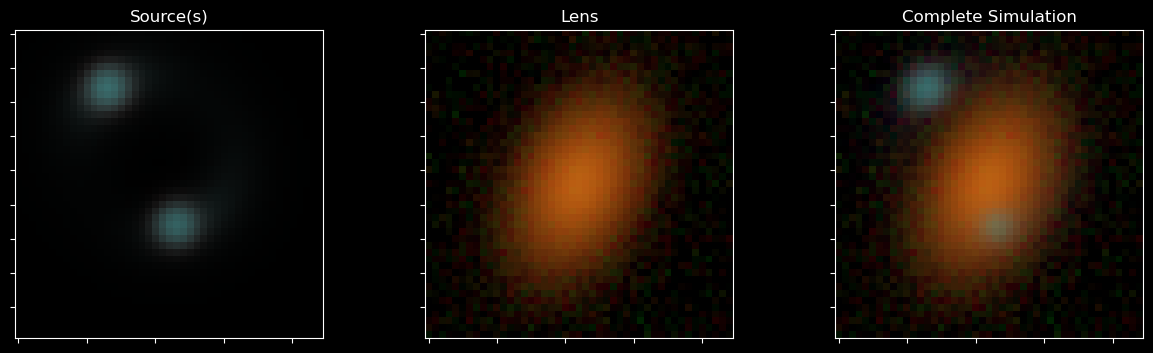

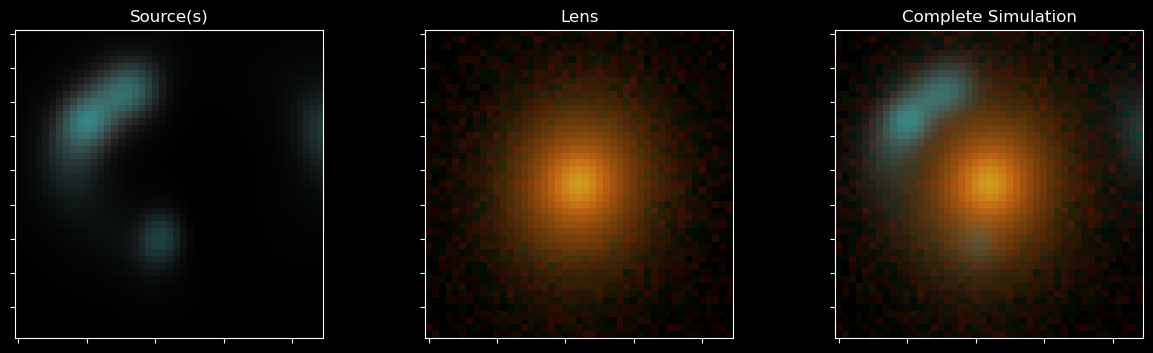

In [12]:
seed, num_sim, filename = 6, 10, 'other' # 4 2 False other
if(cluster):
    seed, num_sim, filename = sys.argv[1], sys.argv[2], sys.argv[3]
run_everything(int(seed), int(num_sim), filename)
